In [2]:
%pip install pytorch-forecasting


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import boto3

# client=boto3.client('sts')
# account=client.get_caller_identity()['Account']

# my_session=boto3.session.Session()
# region=my_session.region_name

# algorithm_name="pytorch-tft-container-test"
# ecr_image='{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account, region, algorithm_name)

# ecr_image

In [7]:
import sagemaker
import uuid

sagemaker_session = sagemaker.Session()
print('SageMaker version: ' + sagemaker.__version__)

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-pytorch-cnn-cifar10'

role = sagemaker.get_execution_role()
checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_path = 's3://{}/checkpoints/checkpoint-{}'.format(bucket, checkpoint_suffix)

print('Checkpointing Path: {}'.format(checkpoint_s3_path))

SageMaker version: 2.107.0
Checkpointing Path: s3://sagemaker-us-east-1-049151007956/checkpoints/checkpoint-fa2a113c


In [8]:
import pandas as pd

data_df = pd.read_csv("../dataset-group-by-day.csv")
# test_df = pd.read_csv("../HistoricalSalesandActive Inventory_3years_testing_no_header.csv", names=['timestamp','item','store','sales'])

# data_df = pd.concat([data_df, test_df])



In [9]:
data_df['time_idx'] = pd.DatetimeIndex(data_df["BILLDATE"]).astype(int)/ 86400000000000   # equals to 1 day

data_df.drop(columns = ['BILLDATE'], inplace = True) # drop bill date

data_df['time_idx'] = data_df['time_idx'].astype(int)
data_df['PLANT'] = data_df['PLANT'].astype(str)
data_df['DISCHAN'] = data_df['DISCHAN'].astype(str)
data_df['solar_month'] = data_df['solar_month'].astype(str)
data_df['solar_day_of_month'] = data_df['solar_day_of_month'].astype(str)
data_df['solar_day_of_week'] = data_df['solar_day_of_week'].astype(str)
data_df['solar_day_of_year'] = data_df['solar_day_of_year'].astype(str)
data_df['lunar_month'] = data_df['lunar_month'].astype(str)
data_df['lunar_day_of_month'] = data_df['lunar_day_of_month'].astype(str)
data_df['MATERIAL'] = data_df['MATERIAL'].astype(str)
data_df['TYPE_JEWEL'] = data_df['TYPE_JEWEL'].astype(str)
data_df['STONES'] = data_df['STONES'].astype(str)
data_df['in_collection'] = data_df['in_collection'].astype(str)

data_df.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869036 entries, 0 to 869035
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   PRODCODE            869036 non-null  object 
 1   PLANT               869036 non-null  object 
 2   DISCHAN             869036 non-null  object 
 3   PR_GROUP            869036 non-null  object 
 4   SOLUONG             869036 non-null  float64
 5   in_collection       869036 non-null  object 
 6   solar_month         869036 non-null  object 
 7   solar_day_of_month  869036 non-null  object 
 8   solar_day_of_week   869036 non-null  object 
 9   solar_day_of_year   869036 non-null  object 
 10  lunar_month         869036 non-null  object 
 11  lunar_day_of_month  869036 non-null  object 
 12  MATERIAL            869036 non-null  object 
 13  TYPE_JEWEL          869036 non-null  object 
 14  STONES              869036 non-null  object 
 15  time_idx            869036 non-nul

In [10]:
import os
import json
def save_local_and_upload_s3(data_df, sagemaker_session, bucket, dir_name = "timeseries_data", data_filename = "data"):
    #create data directory if not exist
    if os.path.isdir(dir_name):
        print("Checkpointing directory {} exists".format(dir_name))
    else:
        print("Creating Checkpointing directory {}".format(dir_name))
        os.makedirs(dir_name)

    data_df.to_parquet('{}/{}.parquet'.format(dir_name, data_filename))   
    print("saved raw data to {}/{}.parquet".format(dir_name, data_filename))
    
    return sagemaker_session.upload_data(path=dir_name, bucket=bucket, key_prefix='data/{}'.format(dir_name))



def metadata_json_upload_s3(training_metadata, sagemaker_session, bucket, dir_name = "timeseries_data", metadata_filename = "data_metadata"):
    #create data directory if not exist
    if os.path.isdir(dir_name):
        print("Checkpointing directory {} exists".format(dir_name))
    else:
        print("Creating Checkpointing directory {}".format(dir_name))
        os.makedirs(dir_name)
    
    with open('{}/{}.json'.format(dir_name, metadata_filename), 'w') as fp:
        json.dump(training_metadata, fp)
        print("saved metadata to {}/{}.json".format(dir_name, metadata_filename))
    
    return sagemaker_session.upload_data(path=dir_name, bucket=bucket, key_prefix='data/{}'.format(dir_name))


In [11]:
import pandas as pd 

inputs = save_local_and_upload_s3(data_df, sagemaker_session, bucket,
                                  dir_name = "timeseries_data/pnj",
                                  data_filename="pnj_training_data")
inputs

Checkpointing directory timeseries_data/pnj exists
saved raw data to timeseries_data/pnj/pnj_training_data.parquet


's3://sagemaker-us-east-1-049151007956/data/timeseries_data/pnj'

In [12]:
# max_prediction_length = 180
max_prediction_length = 7
max_encoder_length = 100

training_metadata = {}
training_metadata['time_idx'] = "time_idx"
training_metadata['target'] = "SOLUONG"
training_metadata['group_ids'] = ["PRODCODE", "PLANT", 'DISCHAN', 'PR_GROUP', 'MATERIAL', 'TYPE_JEWEL', 'STONES']
training_metadata['min_encoder_length'] = 0      # keep encoder length long (as it is in the validation set)
training_metadata['max_encoder_length'] = max_encoder_length
training_metadata['min_prediction_length'] = 1      
training_metadata['max_prediction_length'] = max_prediction_length
training_metadata['static_categoricals'] = ["PRODCODE", "PLANT", 'DISCHAN', 'PR_GROUP', 'MATERIAL','TYPE_JEWEL', 'STONES']
training_metadata['static_reals'] = []
training_metadata['time_varying_known_categoricals'] = ['solar_month', 'solar_day_of_month', 'solar_day_of_week', 'solar_day_of_year', 'lunar_month', 'lunar_day_of_month']
training_metadata['variable_groups'] = {}
training_metadata['time_varying_known_reals'] = ["time_idx"]
training_metadata['time_varying_unknown_categoricals'] = ['in_collection']
training_metadata['time_varying_unknown_reals'] = []
training_metadata['target_normalizer'] = {
                            "normalized_groups": ["PRODCODE", "PLANT", 'DISCHAN', 'PR_GROUP', 'MATERIAL', 'TYPE_JEWEL', 'STONES'],
                            "normalization_transformation": 'softplus'
                        }
training_metadata['dimensions_w_potentially_unseen_values'] = ["PRODCODE", "PLANT", 'DISCHAN', 'PR_GROUP', 'MATERIAL', 'TYPE_JEWEL', 'STONES',
                                                              "lunar_month", "solar_day_of_year"]
training_metadata['add_relative_time_idx'] = True
training_metadata['add_target_scales'] = True
training_metadata['add_encoder_length'] = True
training_metadata['allow_missing_timesteps'] = True

training_metadata['training_cutoff'] = int(data_df["time_idx"].max() - max_prediction_length)
# training_metadata['training_cutoff'] = int(data_df["time_idx"].max())

# upload metadata
metadata_json_upload_s3(training_metadata, sagemaker_session, bucket,
                                    dir_name = "timeseries_data/pnj",
                                    metadata_filename="pnj_metadata")

Checkpointing directory timeseries_data/pnj exists
saved metadata to timeseries_data/pnj/pnj_metadata.json


's3://sagemaker-us-east-1-049151007956/data/timeseries_data/pnj'

In [13]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.data import encoders

cat_encoders = {}
for cat in training_metadata['dimensions_w_potentially_unseen_values']:
    cat_encoders[cat] = encoders.NaNLabelEncoder(add_nan=True)

train_df = data_df[lambda x: x[training_metadata['time_idx']] <= training_metadata['training_cutoff']]
val_df = data_df[lambda x: x[training_metadata['time_idx']] > training_metadata['training_cutoff']]
val_df

/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,
/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be u

,PRODCODE,PLANT,DISCHAN,PR_GROUP,SOLUONG,in_collection,solar_month,solar_day_of_month,solar_day_of_week,solar_day_of_year,lunar_month,lunar_day_of_month,MATERIAL,TYPE_JEWEL,STONES,time_idx
828146,40001310,2106,10,PCM000001,1.0,True,9,24,5,267,8,29,4,0,00,19259
828147,40001311,2106,10,PCM000001,1.0,True,9,24,5,267,8,29,4,0,00,19259
828148,40001316,1269,10,PCM000001,1.0,True,9,24,5,267,8,29,4,0,00,19259
828149,40001329,2106,10,PCM000001,1.0,True,9,24,5,267,8,29,4,0,00,19259
828150,40001331,2106,10,PCM000001,1.0,True,9,24,5,267,8,29,4,0,00,19259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869031,WMI00000099,2106,10,PWFMIQC,1.0,True,9,30,4,273,9,5,W,M,I0,19265
869032,WOR00000219,1333,10,PWMORAC,1.0,True,9,30,4,273,9,5,W,O,R0,19265
869033,WOR00000274,1133,10,PWMORAC,1.0,True,9,30,4,273,9,5,W,O,R0,19265
869034,WOR00000293,1367,10,PWMORAC,1.0,True,9,30,4,273,9,5,W,O,R0,19265


In [14]:
# refine validation dataframe to only contain elements already seen in train dataframe
for category_dimension in training_metadata['group_ids']:
    val_df = val_df[val_df[category_dimension].isin(train_df[category_dimension].unique())]

val_df

,PRODCODE,PLANT,DISCHAN,PR_GROUP,SOLUONG,in_collection,solar_month,solar_day_of_month,solar_day_of_week,solar_day_of_year,lunar_month,lunar_day_of_month,MATERIAL,TYPE_JEWEL,STONES,time_idx
828146,40001310,2106,10,PCM000001,1.0,True,9,24,5,267,8,29,4,0,00,19259
828147,40001311,2106,10,PCM000001,1.0,True,9,24,5,267,8,29,4,0,00,19259
828148,40001316,1269,10,PCM000001,1.0,True,9,24,5,267,8,29,4,0,00,19259
828149,40001329,2106,10,PCM000001,1.0,True,9,24,5,267,8,29,4,0,00,19259
828150,40001331,2106,10,PCM000001,1.0,True,9,24,5,267,8,29,4,0,00,19259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869031,WMI00000099,2106,10,PWFMIQC,1.0,True,9,30,4,273,9,5,W,M,I0,19265
869032,WOR00000219,1333,10,PWMORAC,1.0,True,9,30,4,273,9,5,W,O,R0,19265
869033,WOR00000274,1133,10,PWMORAC,1.0,True,9,30,4,273,9,5,W,O,R0,19265
869034,WOR00000293,1367,10,PWMORAC,1.0,True,9,30,4,273,9,5,W,O,R0,19265


In [15]:
# training = TimeSeriesDataSet(
#         train_df,
#         time_idx= training_metadata['time_idx'],
#         target= training_metadata['target'],
#         group_ids= training_metadata['group_ids'],
#         min_encoder_length= training_metadata['min_encoder_length'],  
#         max_encoder_length= training_metadata['max_encoder_length'],
#         min_prediction_length=training_metadata['min_prediction_length'],
#         max_prediction_length=training_metadata['max_prediction_length'],
#         static_categoricals=training_metadata['static_categoricals'],
#         static_reals=training_metadata['static_reals'],
#         time_varying_known_categoricals=training_metadata['time_varying_known_categoricals'],
#         variable_groups= training_metadata['variable_groups'],  # group of categorical variables can be treated as one variable
#         time_varying_known_reals= training_metadata['time_varying_known_reals'],
#         time_varying_unknown_categoricals= training_metadata['time_varying_unknown_categoricals'],
#         time_varying_unknown_reals= training_metadata['time_varying_unknown_reals'],
#         target_normalizer=GroupNormalizer(
#                 groups= training_metadata['target_normalizer']['normalized_groups'], 
#                 transformation= training_metadata['target_normalizer']['normalization_transformation']
#         ),  # use softplus and normalize by group
#         add_relative_time_idx= training_metadata['add_relative_time_idx'],
#         add_target_scales= training_metadata['add_target_scales'],
#         add_encoder_length= training_metadata['add_encoder_length'],
#         allow_missing_timesteps = training_metadata["allow_missing_timesteps"],
#         categorical_encoders= cat_encoders
#     )

# validation = TimeSeriesDataSet.from_dataset(training, pd.concat([train_df, val_df]), predict=True, stop_randomization=True)
# batch_size = 128  # set this between 32 to 128
# val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [16]:
use_spot_instances = False
max_run=6000      # in seconds, after this, job will be terminated
max_wait = 10 * max_run if use_spot_instances else None
local_image_name = 'pytorch-tft-container-test'



In [17]:
# inputs = "s3://sagemaker-us-east-1-551329315830/checkpoints/checkpoint-test"
# ecr_image = "551329315830.dkr.ecr.us-east-1.amazonaws.com/pytorch-tft-container-test"
# RoleName = "arn:aws:iam::551329315830:role/service-role/trung-test-role-viqdlwga"


In [ ]:
from sagemaker.pytorch import PyTorch
from sagemaker.estimator import Estimator
from sagemaker.debugger import TensorBoardOutputConfig


tft_hyperparameters = {
        'data-filename': "pnj_training_data.parquet",
        'metadata-filename': "pnj_metadata.json",
    
        'max-prediction-length' : max_prediction_length,
        'max-encoder-length' : max_encoder_length,
        'num-epochs' : 100,
        'early-stopping-patience' : 5,
        'multiprocessing-workers' : 5,


        'dropout-rate' : 0.1,
        'hidden-layer-size' : 160,
        'learning-rate' : 0.03,
        'minibatch-size' : 64,
        'max-gradient-norm' : 0.1,
#         'max-gradient-norm' : 1,
        'num-heads' : 4,
    
        'run-mode' : "real",
        'main-training-metric' : "val_RMSE"
    
    }

tensorboard_output_config = TensorBoardOutputConfig(
    s3_output_path='s3://{}/tensorboard'.format(bucket),
    container_local_output_path='/lightning_logs'
)

spot_estimator  = PyTorch(entry_point='TFT_docker/TFT.py',
                            dependencies=['TFT_docker/requirements.txt'],
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            instance_count=1,
#                             instance_type='local',
#                             instance_type='ml.p3.2xlarge',
                            # instance_type='ml.p2.xlarge',
                            instance_type='ml.g4dn.xlarge',
                            base_job_name='tft-pytorch-spot-1',
                            hyperparameters=tft_hyperparameters,
                            checkpoint_s3_uri=checkpoint_s3_path,
                            debugger_hook_config=False,
                            input_mode = 'File',
                            use_spot_instances=use_spot_instances,
                            max_run=max_run,
                            max_wait=max_wait,
                            tensorboard_output_config=tensorboard_output_config,
                            metric_definitions=[
                                   {'Name': 'train:epoch', 'Regex': "'epoch':(.*?)}"},
                                   {'Name': 'train:loss', 'Regex': "'train_loss_step':(.*?),"},
                                   {'Name': 'train:SMAPE', 'Regex': "'train_SMAPE_step':(.*?),"},
                                   {'Name': 'train:MAE', 'Regex': "'train_MAE_step':(.*?),"},
                                   {'Name': 'train:RMSE', 'Regex': "'train_RMSE_step':(.*?),"},
                                   {'Name': 'train:MAPE', 'Regex': "'train_MAPE_step':(.*?),"},
                                   {'Name': 'val:loss', 'Regex': "'val_loss':(.*?),"},
                                   {'Name': 'val:SMAPE', 'Regex': "'val_SMAPE':(.*?),"},
                                   {'Name': 'val:MAE', 'Regex': "'val_MAE':(.*?),"},
                                   {'Name': 'val:RMSE', 'Regex': "'val_RMSE':(.*?),"},
                                   {'Name': 'val:MAPE', 'Regex': "'val_MAPE':(.*?),"},
                                ]
                           )

spot_estimator.fit(
                inputs,
                logs = 'All'
            )

2022-10-19 14:52:55 Starting - Starting the training job...
2022-10-19 14:53:18 Starting - Preparing the instances for trainingProfilerReport-1666191175: InProgress
.........
2022-10-19 14:54:54 Downloading - Downloading input data
2022-10-19 14:54:54 Training - Downloading the training image....................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-10-19 14:58:07,953 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-10-19 14:58:07,984 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-10-19 14:58:07,992 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-10-19 14:58:08,434 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.6 -m pip install -r requirements.txt

2022-10-19 14:58:19 Training - Training image download completed. Training in 

## Hyperparameter Tuning

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.tuner import WarmStartConfig,WarmStartTypes

hyperparameter_ranges = {
    'dropout-rate' : ContinuousParameter(0.00001, 0.01, scaling_type="Logarithmic"),
    'learning-rate' : ContinuousParameter(0.00001, 0.01, scaling_type="Logarithmic"),
    'minibatch-size' : IntegerParameter(64, 256),
    'max-gradient-norm' : ContinuousParameter(0.00001, 0.01, scaling_type="Logarithmic"),
}

parent_tuning_job_name = "pytorch-training-220906-0950"
warm_start_config = WarmStartConfig(warm_start_type=WarmStartTypes.IDENTICAL_DATA_AND_ALGORITHM, parents={parent_tuning_job_name})


objective_metric_name = 'val:RMSE'
objective_type = "Minimize"
metric_definitions = [
                       {'Name': 'train:epoch', 'Regex': "'epoch':(.*?),"},
                       {'Name': 'train:loss', 'Regex': "'train_loss_epoch':(.*?),"},
                       {'Name': 'train:SMAPE', 'Regex': "'train_SMAPE_epoch':(.*?),"},
                       {'Name': 'train:MAE', 'Regex': "'train_MAE_epoch':(.*?),"},
                       {'Name': 'train:RMSE', 'Regex': "'train_RMSE_epoch':(.*?),"},
                       {'Name': 'train:MAPE', 'Regex': "'train_MAPE_epoch':(.*?),"},
                       {'Name': 'val:loss', 'Regex': "'val_loss':(.*?),"},
                       {'Name': 'val:SMAPE', 'Regex': "'val_SMAPE':(.*?),"},
                       {'Name': 'val:MAE', 'Regex': "'val_MAE':(.*?),"},
                       {'Name': 'val:RMSE', 'Regex': "'val_RMSE':(.*?),"},
                       {'Name': 'val:MAPE', 'Regex': "'val_MAPE':(.*?),"},
                    ]
hpo_tuner = HyperparameterTuner(
            spot_estimator,
            objective_metric_name,
            hyperparameter_ranges,
            metric_definitions,
            max_jobs = 50,
            max_parallel_jobs = 1,
            objective_type = objective_type,
    
            base_tuning_job_name='warmstart',
            warm_start_config=warm_start_config,
        )


hpo_tuner.fit(inputs)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.............................................................................................................................

# Test the model on testing data

#### Using model.tar.gz file after model completion (last checkpoint)

In [22]:
model_s3_path = spot_estimator.model_data
model_s3_path

's3://sagemaker-us-east-1-551329315830/tft-pytorch-spot-1-2022-09-05-13-26-13-257/output/model.tar.gz'

In [23]:
# model_s3_path = 's3://sagemaker-us-east-1-551329315830/tft-pytorch-spot-1-2022-08-26-15-38-14-680/output/model.tar.gz'

In [24]:
from sagemaker.s3 import S3Downloader
import tarfile
from pytorch_forecasting import TemporalFusionTransformer

def download_data_from_s3(s3_uri, sagemaker_session):
    S3Downloader.download(
                        s3_uri=s3_uri, 
                        local_path = "./trained_model_artifact",
                        sagemaker_session=sagemaker_session
                )
    return "./trained_model_artifact/model.tar.gz"

model_path = download_data_from_s3(model_s3_path, sagemaker_session)
tar = tarfile.open(model_path, "r:gz")

checkpointed_model = TemporalFusionTransformer.load_from_checkpoint(tar.extractfile(member=tar.getmember(name="model_trainer.ckpt")))
best_tft = checkpointed_model


#### Using best model checkpoint ".ckpt" file

In [26]:
checkpt_path = 's3://sagemaker-us-east-1-551329315830/checkpoints/checkpoint-6e582038/pytorch-training-220906-0950-026-d663d12f/epoch=24-val_RMSE=9.55.ckpt'
checkpointed_model = TemporalFusionTransformer.load_from_checkpoint(checkpt_path)
best_tft = checkpointed_model


In [27]:
print(data_df['time_idx'].max())
best_tft.predict(data_df, return_index = True)[1]

17347


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)


,time_idx,item,store
0,17338,1,1
1,17338,1,2
2,17338,1,3
3,17338,1,4
4,17338,1,5


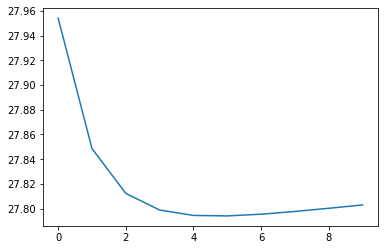

In [28]:
import matplotlib.pyplot as plt
plt.plot(best_tft.predict(data_df, return_index = True)[0][0])

17347

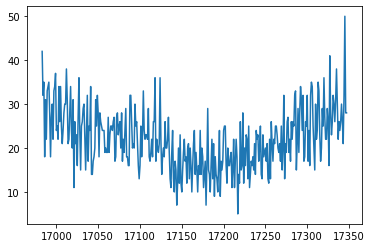

In [29]:
train_target = data_df[(data_df['item'] == "1") & (data_df['store'] == "1")]
train_target
plt.plot(train_target['time_idx'][-365:], train_target['sales'][-365:])
train_target['time_idx'].max()


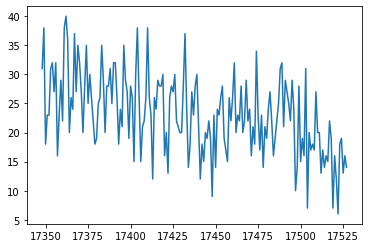

In [30]:
import pandas as pd 
actual_df = pd.read_csv("HistoricalSalesandActive Inventory_3years_testing_no_header.csv", names=['timestamp','item','store','sales'])
actual_df['time_idx'] = pd.DatetimeIndex(actual_df["timestamp"]).astype(int)/ 86400000000000   # equals to 1 day
actual_df['time_idx'] = actual_df['time_idx'].astype(int)

actual_target = actual_df[(actual_df['item'] == 1) & (actual_df['store'] == 1)][:180]

plt.plot(actual_target['time_idx'], actual_target['sales'])

In [31]:
checkpointed_model.predict(val_dataloader, return_index = True)[1]

,time_idx,item,store
0,17338,1,1
1,17338,1,2
2,17338,1,3
3,17338,1,4
4,17338,1,5


In [32]:
# prediction:
import torch

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = checkpointed_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(6.5864)

In [33]:
# next(iter(val_dataloader))[0]

rmse:  8.815658977109061


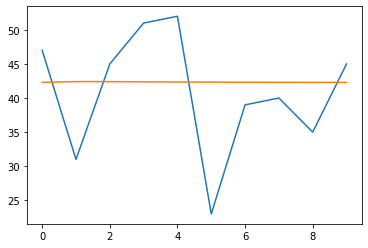

In [34]:
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

item_idx = 2
horizon = 180
print('rmse: ', math.sqrt(mean_squared_error(actuals[item_idx][:horizon],predictions[item_idx][:horizon])))
plt.plot(actuals[item_idx][:horizon])
plt.plot(predictions[item_idx][:horizon])

IndexError: index 5 is out of bounds for dimension 0 with size 5

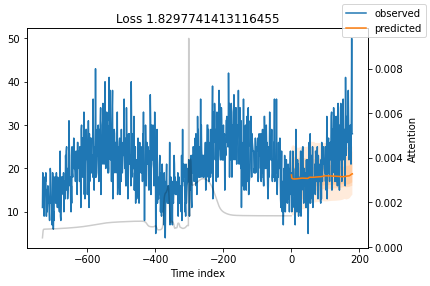

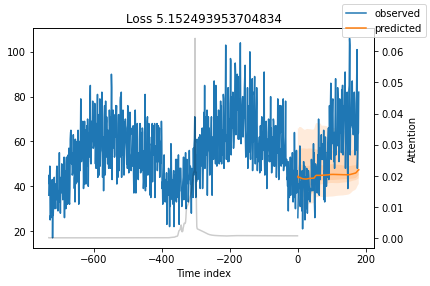

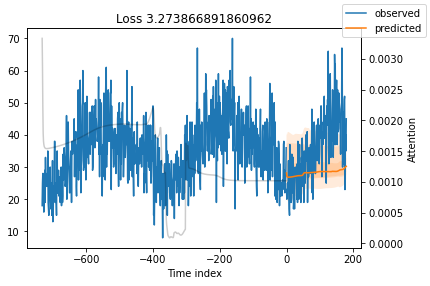

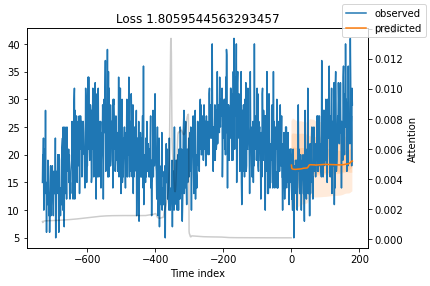

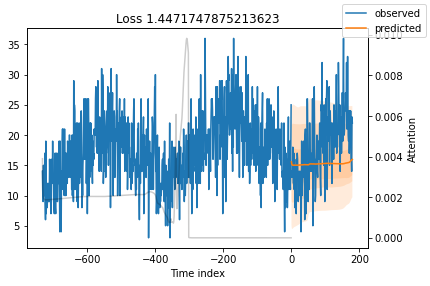

In [21]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);